### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = 'sample2A.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

In [3]:
print(centroids)

[[0 2]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 0]
 [0 0]]


 ## Extract Droplet Centroids

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "sample4A.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply a Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (3, 3), 0)

# Use Otsu's thresholding to segment pores
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological opening to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Detect connected components
num_labels, labels = cv2.connectedComponents(cleaned)

# Compute centroids
centers = []
for label_id in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label_id).astype(np.uint8)
    M = cv2.moments(mask, binaryImage=True)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers.append((cX, cY))

# Convert grayscale to BGR for drawing
marked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
print(centroids)
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=5)
plt.title('Detected Droplet Centers')
plt.show()



NameError: name 'centroids' is not defined

[[516 672]
 [384 671]
 [ 39 656]
 [712 652]
 [122 643]
 [808 635]
 [218 637]
 [453 612]
 [765 593]
 [585 607]
 [332 595]
 [153 576]
 [686 567]
 [ 48 556]
 [814 533]
 [235 528]
 [428 511]
 [631 494]
 [140 479]
 [731 476]
 [526 475]
 [667 426]
 [334 464]
 [ 50 435]
 [809 430]
 [616 415]
 [233 415]
 [431 405]
 [  9 370]
 [143 372]
 [759 362]
 [331 352]
 [653 349]
 [ 49 331]
 [538 343]
 [236 314]
 [558 273]
 [615 284]
 [454 252]
 [423 293]
 [800 282]
 [709 266]
 [504 245]
 [638 234]
 [324 251]
 [134 259]
 [ 37 218]
 [231 211]
 [578 212]
 [401 187]
 [778 176]
 [748 139]
 [497 158]
 [ 92 155]
 [740 118]
 [670 168]
 [312 127]
 [588 109]
 [189 112]
 [ 24  93]
 [813  73]
 [421  86]
 [746  72]
 [667  62]
 [513  66]
 [ 99  48]
 [798  30]
 [713  15]
 [589  23]
 [465   4]
 [349  31]
 [270  34]
 [226  12]
 [166   5]
 [ 13  16]]


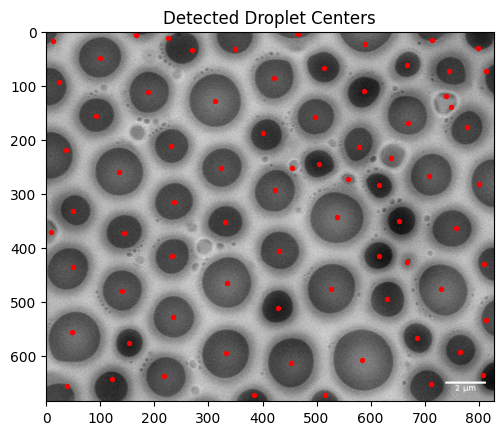

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "sample6B.jpg"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply median blur to reduce noise
blurred = cv2.medianBlur(image, 5)

# Use Otsu's thresholding to create a binary mask
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological closing to fill small gaps
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Detect edges using Canny edge detector
edges = cv2.Canny(closed, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert to color image for visualization
output_final = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw detected pore centers
centroids = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append((cx, cy))

# Convert to NumPy array
centroids = np.array(centroids)
print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()

[[305 596]
 [752 587]
 [769 578]
 [594 583]
 [396 583]
 [131 583]
 [673 549]
 [752 547]
 [328 522]
 [203 485]
 [257 475]
 [133 484]
 [ 67 444]
 [768 464]
 [568 426]
 [695 445]
 [ 11 426]
 [114 418]
 [516 421]
 [317 413]
 [123 362]
 [403 343]
 [ 49 341]
 [498 323]
 [123 297]
 [194 298]
 [693 275]
 [373 271]
 [  3 252]
 [153 230]
 [ 74 233]
 [240 221]
 [703 197]
 [330 198]
 [776 219]
 [101 169]
 [666 134]
 [ 26 144]
 [511 110]
 [102 100]
 [731 110]
 [692  49]
 [537  42]
 [169  47]
 [755  25]
 [683   6]
 [583   4]
 [460  14]
 [349  17]
 [251   9]
 [ 42  29]]


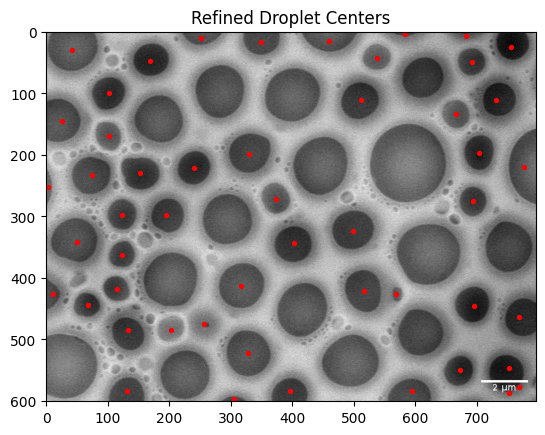

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample6A.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Step 2: Apply Otsu’s Thresholding for better segmentation
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 3: Morphological Operations to refine segmentation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Step 4: Find Contours and Filter by Area
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

centroids = []
min_area = 100  # Adjust to remove small noise
max_area = 5000  # Adjust to exclude large non-droplet objects

for contour in contours:
    area = cv2.contourArea(contour)
    if min_area < area < max_area:
        # Use Convex Hull to refine the droplet shape
        hull = cv2.convexHull(contour)
        M = cv2.moments(hull)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append([cx, cy])

# Convert to numpy array
centroids = np.array(centroids)
print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Refined Droplet Centers')
plt.show()


[[792 599]
 [693 598]
 [305 596]
 [751 580]
 [594 583]
 [396 583]
 [131 583]
 [138 550]
 [121 527]
 [673 549]
 [750 545]
 [225 556]
 [286 510]
 [494 535]
 [ 36 543]
 [328 522]
 [ 52 482]
 [564 476]
 [204 484]
 [257 476]
 [166 469]
 [257 463]
 [148 457]
 [612 489]
 [132 484]
 [735 436]
 [155 434]
 [ 33 426]
 [ 67 444]
 [768 464]
 [148 423]
 [568 426]
 [153 415]
 [695 445]
 [416 451]
 [ 12 427]
 [114 418]
 [ 57 403]
 [ 53 394]
 [517 421]
 [317 413]
 [200 403]
 [123 362]
 [706 334]
 [181 331]
 [165 331]
 [621 361]
 [160 316]
 [ 88 313]
 [403 343]
 [ 49 341]
 [662 307]
 [753 350]
 [ 77 303]
 [643 294]
 [498 323]
 [500 281]
 [123 297]
 [194 298]
 [294 305]
 [648 258]
 [693 275]
 [373 271]
 [111 248]
 [655 245]
 [  3 252]
 [375 208]
 [153 230]
 [ 74 233]
 [239 222]
 [287 189]
 [150 185]
 [445 218]
 [686 165]
 [330 198]
 [703 197]
 [776 219]
 [707 159]
 [ 58 158]
 [588 213]
 [101 169]
 [666 134]
 [ 26 144]
 [181 142]
 [793  92]
 [794  84]
 [789  78]
 [511 110]
 [102 100]
 [794  73]
 [732 110]

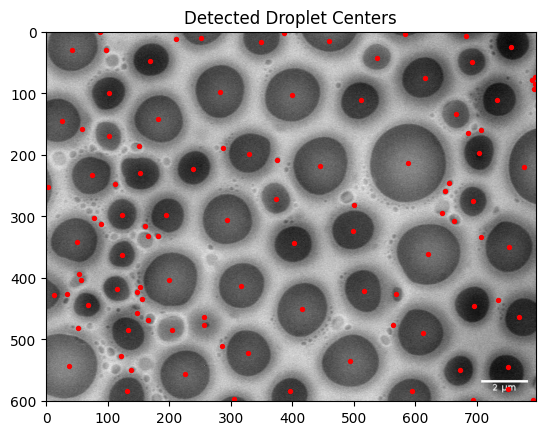

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "sample6A.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to smooth the image
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply thresholding to create a binary image
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw on
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Calculate and draw centroids
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX, cY))
        cv2.circle(output, (cX, cY), 3, (0, 0, 255), -1)

# Show the output image with centroids

# Convert to NumPy array
centroids = np.array(centroids)
print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()


## Perform Voronoi Tessellation

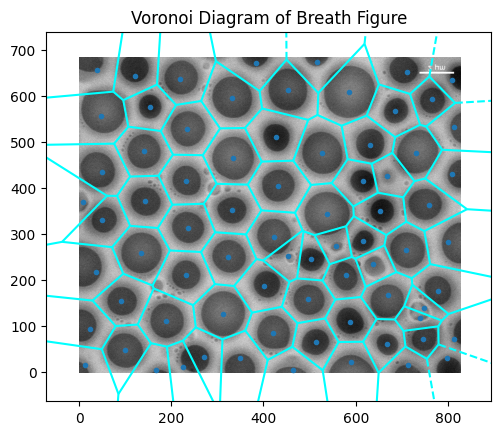

In [22]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Compute Voronoi Tessellation
vor = Voronoi(centroids)

# Plot Voronoi Diagram
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


## Analyze Voronoi Cell Shapes

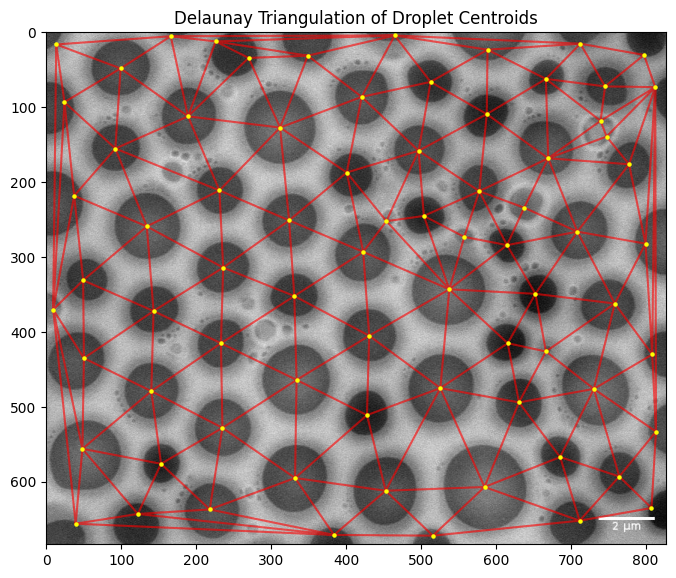

In [23]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load SEM Image
# Preprocess Image (assuming previous steps are done and centroids are detected)
# This part assumes that centroids are already identified, e.g., using contours or other method

# Example centroid array (replace with actual centroids)
# centroids = np.array([[100, 150], [200, 250], [300, 350], ...])

# Compute Delaunay Triangulation (corrected to use centroids as (x, y))
tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


## Quantitative Metrics

Hexagonality Ratio: 0.40


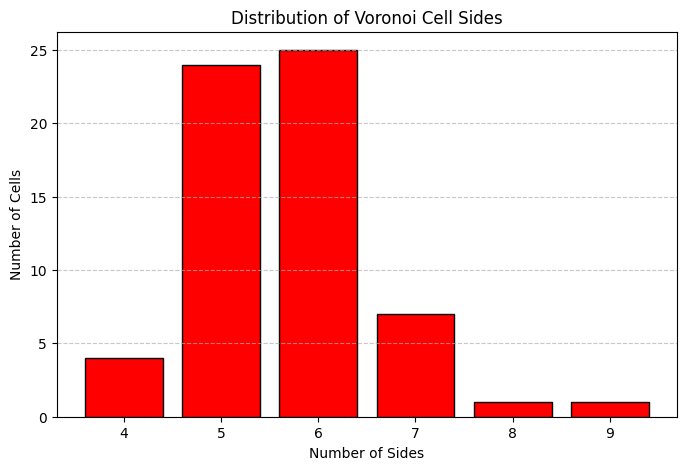

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct Graph from Voronoi
graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')

# Count the number of cells for each number of sides
side_counts = {}
for n, attr in graph.nodes(data=True):
    sides = attr['sides']
    if sides in side_counts:
        side_counts[sides] += 1
    else:
        side_counts[sides] = 1

# Sort the sides for better visualization
sorted_sides = sorted(side_counts.keys())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
plt.xlabel('Number of Sides')
plt.ylabel('Number of Cells')
plt.title('Distribution of Voronoi Cell Sides')
plt.xticks(sorted_sides)  # Ensure all side numbers are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

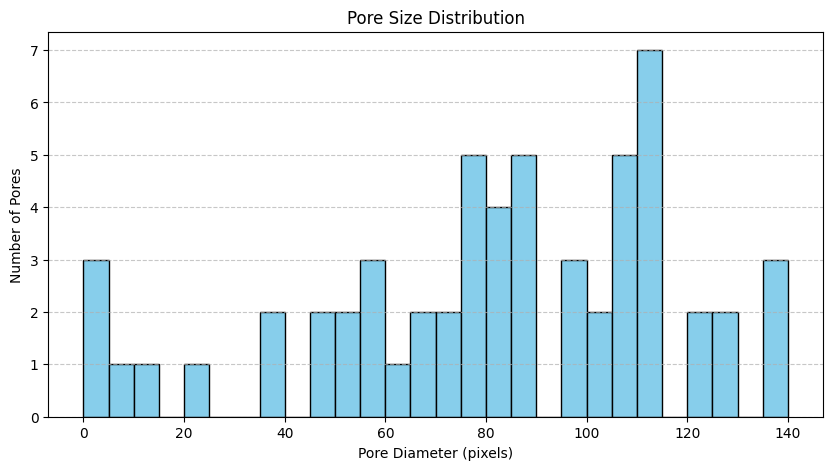

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample2A.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Preprocess the Image (Thresholding and Cleaning)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Step 2: Find Contours of Pores
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate Pore Diameters
pore_diameters = []
for contour in contours:
    area = cv2.contourArea(contour)
    equivalent_diameter = 2 * np.sqrt(area / np.pi)  # Diameter of a circle with the same area
    pore_diameters.append(equivalent_diameter)

# Step 4: Bin the Pore Diameters for the Bar Chart
# Define bin edges (adjust based on your pore size range)
bin_edges = np.arange(0, max(pore_diameters) + 5, 5)  # Bins of 5 units (e.g., pixels)
hist, bin_edges = np.histogram(pore_diameters, bins=bin_edges)

# Step 5: Plot the Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Pore Diameter (pixels)')
plt.ylabel('Number of Pores')
plt.title('Pore Size Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()